# STIMULATION

### Testing Waveforms

This is the stimulation playground. The function that generates the stimulation is going to be used to make different stimulation waveforms.

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def generate_stim(duration, dt=1e-4, stim_on=0., nr_of_trains=5, nr_of_pulses=4, stim_freq=5, stim_type="monophasic", pulse_width=.2e-3, pulse_freq=100, ipi=.1e-3):
    ''' Generate a pulse train to be used as the stimulation waveform.

    Parameters:
    ---------------------------------------------------------------------------
    *       duration    :   stimulation waveform duration - [sec]
    |
    *           dt      :   sampling rate - [sec]
    |
    *       stim_on     :   stimulation start time - [sec]
    |
    *   nr_of_trains    :   number of pulse trains i.e. groups of pulses - [1]
    |
    *   nr_of_pulses    :   number of pulses per group - [1]
    |
    *       stim_freq   :   stimulation frequency - [Hz]
    |
    *       stim_type   :   "monophasic" | "anodic-first" | "cathodic-first"
    |
    *       pulse_width :   width (in time) of pulse ON phase - [sec]
    |
    *       pulse_freq  :   pulse frequency; determines ON duration - [Hz]
    |
    *               ipi :   inter-pulse interval - [sec]
    ---------------------------------------------------------------------------
    '''

    # step 0: parse arguments and evaluate
    if pulse_width > 1/pulse_freq:
        raise ValueError('Pulse width is too large for given pulse frequency.')


    # calculate single pulse duration
    pd = 1./pulse_freq                  # pulse duration [sec]
    pd_samples = int(pd/dt)             # pulse duration [samples]
    pw_samples = int(pulse_width/dt)    # pulse width [samples]
    ipi_samples = int(ipi/dt)           # inter-pulse interval [samples]

    # step 1: create a single pulse
    if stim_type.lower() == "monophasic":
        # monophasic pulse
        pulse = np.zeros((1,pd_samples), dtype="int")
        pulse[0,:pw_samples] = 1        # ON state
    else:
        # biphasic pulse
        pulse = np.zeros((1,pd_samples), dtype="int")
        pulse[0,:pw_samples]            # ON state
        idx = 0
        pulse[0,0:idx+pw_samples] = 1
        idx += pw_samples
        pulse[0,idx:idx+ipi_samples] = 0
        idx += ipi_samples
        pulse[0,idx:idx+pw_samples] = -1

        if stim_type.lower()=="cathodic-first":
            pulse *= -1

    # step 2: repeat the pulse and add the delay between bursts
    pulse_train = np.tile(pulse, nr_of_pulses)
    delay = int(1/stim_freq/dt - len(pulse_train[0]))
    pulse_train = np.append(pulse_train, np.zeros((1,delay)), axis=1)

    # step 3: repeat the whole group
    waveform_ = np.tile(pulse_train, nr_of_trains) # temp array
    
    # step 4: create the stimulation waveform
    tv = np.linspace(0, duration, int(duration/dt)+1)
    stimulation = np.zeros(tv.shape, dtype="int")

    # find the nearest time value to the stimulation start time
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx], idx

    v, i = find_nearest(tv, stim_on)

    # step 5: clip the waveform, removing unused trailing zeros
    idxs = np.where(waveform_.flatten() != 0)
    idx = np.max(idxs)
    waveform = waveform_[0,:idx+10]
    
    # check that waveform is not too large
    if (i+len(waveform) > len(tv)):
        raise ValueError('Generated signal too large for given duration.')

    stimulation[i:i+len(waveform)] = waveform

    return stimulation


In [66]:
# Globals
second = s = 1
millisecond = ms = 1e-3
dt = 0.1*ms
duration = 1*second
tv = np.linspace(0, duration, int(duration/dt)+1)

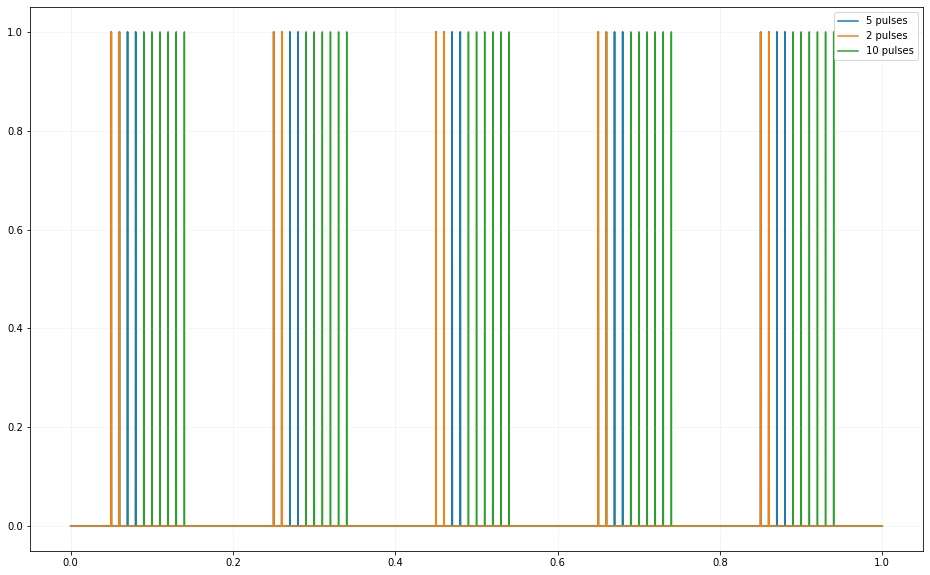

In [79]:
# Parameters
stim_on = 50*ms

stim1 = generate_stim(duration, stim_on=stim_on)
stim2 = generate_stim(duration, stim_on=stim_on, nr_of_pulses=2)
stim3 = generate_stim(duration, stim_on=stim_on, nr_of_pulses=10)

fig, axs = plt.subplots(1,1)
fig.set_size_inches(16,10)
axs.plot(tv, stim1, label='5 pulses', zorder=2)
axs.plot(tv, stim2, label='2 pulses', zorder=3)
axs.plot(tv, stim3, label='10 pulses', zorder=1)
axs.legend(loc=0)
axs.grid(linestyle='-', linewidth=.5, alpha=0.25)

plt.show()
